In [79]:
#initialization
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice
import scipy.linalg as la
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.visualization import plot_histogram

In [80]:
U = np.load("U.npy")

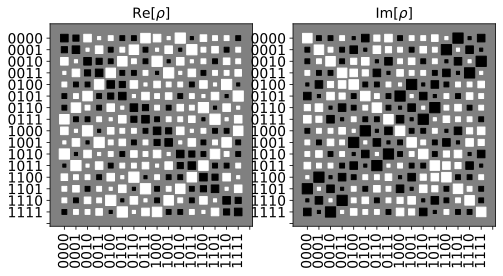

In [81]:
#Observe the Unitary U:
from qiskit.visualization import plot_state_hinton
plot_state_hinton(U)

In [83]:
#Diagonalize the unitary U and name it V:
from scipy.linalg import hadamard
H = hadamard (16, dtype=complex)/4
V = H @ U @H

In [84]:
#Kick out the near zero entries of V:
for i in range(16):
    for j in range(16):
        if abs(V[i,j])<10**(-6):
            V[i,j] = 0

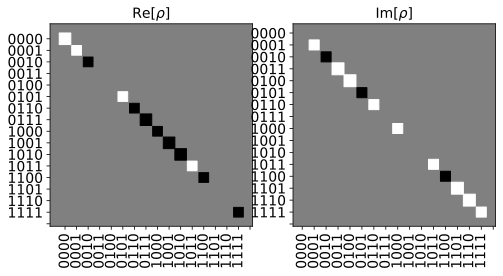

In [85]:
#Observe the dagonal matrix V:
plot_state_hinton(V)

In [86]:
#Take a look at diagonal entries(multipliers of pi) of V:
for i in range(16):
    print(np.angle(V[i,i])/np.pi)

3.9894978426343606e-17
0.25000000000000006
-0.75
0.5
0.5
-0.25000000000000006
0.75
-1.0
0.75
1.0
1.0
0.25
-0.75
0.5
0.5
0.7499999999999999


In [91]:
from qiskit.aqua.circuits import FourierTransformCircuits as QFT

def buildCopmutationalBasis (indexString):
    #indexString example: 0110 which means we want to build this comp. basis: \ket{0}\otimes\ket{1}\ket                             {1}\otimes\ket{0}
    ket0 = np.array([1,0])
    ket1 = np.array([0,1])
    vec = np.zeros(8)
    basis = np.zeros(16)
    index = 0
    for s in indexString:
        if s == '0':
            vec[index:index+2] = ket0
        else:
            vec[index:index+2] = ket1
        index += 2
    basis = np.kron(vec[0:2],np.kron(vec[2:4],np.kron(vec[4:6],vec[6:8])))
    return basis

def CoroQPEonU(indexString):
    
    InputReg = buildCopmutationalBasis (indexString)    

    qr = QuantumRegister(7, 'q')
    cr = ClassicalRegister(3, 'c')
    qpe = QuantumCircuit(qr, cr)
    
    qpe.initialize(InputReg,[3,4,5,6])
    qpe.h(0)
    qpe.h(1)
    qpe.h(2)
    
    for j in range(2, -1, -1):
        for k in range(2**j):
            #V.control([1,j])
            qpe.crz(np.pi/4, j, 3)
            qpe.crz(5*np.pi/4, j, 4)
            qpe.crz(2*np.pi/4, j, 5)
            qpe.crz(3*np.pi/4, j, 6)

            qpe.h(4)
            qpe.ccx(j, 3, 4)
            qpe.h(4)
            qpe.h(5)
            qpe.ccx(j, 4, 5)
            qpe.ccx(j, 3, 5)
            qpe.h(5)
            qpe.h(6)
            qpe.ccx(j, 4, 6)
            qpe.h(6)
    #Apply IQFT on result register (qubits=[0,1,2]):
    QFT.construct_circuit(circuit=qpe, qubits=qr[:3], inverse=True)
    qpe.measure([0, 1, 2], [0, 1, 2])
    
    emulator = Aer.get_backend('qasm_simulator')
    job = execute(qpe, emulator, shots=10)
    hist = job.result().get_counts()

    return hist    

{'010': 4, '011': 6}


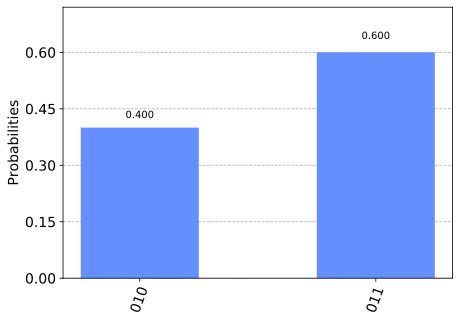

In [94]:
indexString = '0000'
hist = CoroQPEonU(indexString)
print(hist)
plot_histogram(hist)